## Extra nlp features based on letter ngrams and SVD

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)
import seaborn as sns
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12
from tqdm import tqdm, tqdm_notebook
import itertools as it
import pickle
import glob
import os
import string

from scipy import sparse

import nltk
import spacy

from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, make_scorer
from sklearn.decomposition import TruncatedSVD

from scipy.optimize import minimize

import eli5
from IPython.display import display

import xgboost as xgb

/home/ubuntu/anaconda2/envs/qenv/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## load data

In [2]:
df_train = pd.read_csv('data/train_clean_vB.csv', 
                       dtype={
                           'q1_clean_vB': np.str,
                           'q2_clean_vB': np.str
                       })



df_test = pd.read_csv('data/test_clean_vB.csv', 
                      dtype={
                          'q1_clean_vB': np.str,
                          'q2_clean_vB': np.str
                      })

In [4]:
df_train.rename(columns={"q1_clean_vB":"question1", "q2_clean_vB":"question2"}, inplace=True)
df_test.rename(columns={"q1_clean_vB":"question1", "q2_clean_vB":"question2"}, inplace=True)

df_train['test_id'] = -1
df_test['id'] = -1
df_test['qid1'] = -1
df_test['qid2'] = -1
df_test['is_duplicate'] = -1

df = pd.concat([df_train, df_test])
df['question1'] = df['question1'].fillna('')
df['question2'] = df['question2'].fillna('')
df['uid'] = np.arange(df.shape[0])
df = df.set_index(['uid'])
print df.dtypes
del(df_train, df_test)

id               int64
is_duplicate     int64
qid1             int64
qid2             int64
question1       object
question2       object
test_id          int64
dtype: object


In [21]:
df = pd.read_csv("data/cache/extra_features_v2.csv")

In [22]:
ix_train = np.where(df['id'] >= 0)[0]
ix_test = np.where(df['id'] == -1)[0]
ix_is_dup = np.where(df['is_duplicate'] == 1)[0]
ix_not_dup = np.where(df['is_duplicate'] == 0)[0]

### helper functions

In [4]:
def cosine_sparse (m_q1_tf,m_q2_tf):
    
    v_num = np.array(m_q1_tf.multiply(m_q2_tf).sum(axis=1))[:, 0]
    v_den = np.array(np.sqrt(m_q1_tf.multiply(m_q1_tf).sum(axis=1)))[:, 0] * \
            np.array(np.sqrt(m_q2_tf.multiply(m_q2_tf).sum(axis=1)))[:, 0]
    v_num[np.where(v_den == 0)] = 1
    v_den[np.where(v_den == 0)] = 1

    v_score = 1 - v_num/v_den
    
    return v_score

In [5]:
def euclidean_sparse (m_q1_tf,m_q2_tf):
        
    v_score = (m_q1_tf - m_q2_tf)
    v_score = np.sqrt(np.array(v_score.multiply(v_score).sum(axis=1))[:, 0])

    return v_score
    
 

In [6]:
def save_sparse_csr(fname, sm):
    np.savez(fname, 
             data=sm.data, 
             indices=sm.indices,
             indptr=sm.indptr, 
             shape=sm.shape)

def load_sparse_csr(fname):
    loader = np.load(fname)
    return sparse.csr_matrix((
        loader['data'], 
        loader['indices'], 
        loader['indptr']),
        shape=loader['shape'])


In [7]:

def plot_real_feature(fname):
    plt.rcParams['figure.figsize'] = 16, 12
    
    
    fig = plt.figure()
    ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
    ax3 = plt.subplot2grid((3, 2), (2, 0))
    ax4 = plt.subplot2grid((3, 2), (2, 1))
    ax1.set_title('Distribution of %s' % fname, fontsize=20)
    sns.distplot(df.loc[ix_train][fname], 
                 bins=50, 
                 ax=ax1)    
    sns.distplot(df.loc[ix_is_dup][fname], 
                 bins=50, 
                 ax=ax2,
                 label='is dup')    
    sns.distplot(df.loc[ix_not_dup][fname], 
                 bins=50, 
                 ax=ax2,
                 label='not dup')
    ax2.legend(loc='upper right', prop={'size': 18})
    sns.boxplot(y=fname, 
                x='is_duplicate', 
                data=df.loc[ix_train], 
                ax=ax3)
    sns.violinplot(y=fname, 
                   x='is_duplicate', 
                   data=df.loc[ix_train], 
                   ax=ax4)
    plt.show()

### load cached data or do CountVectorizer

In [7]:
%%time
if os.path.isfile('tmp/cv_char.pkl') and os.path.isfile('tmp/ch_freq.pkl'):
    print "loading existing files"
    with open('tmp/cv_char.pkl', 'rb') as f:
        cv_char = pickle.load(f)
    with open('tmp/ch_freq.pkl', 'rb') as f:
        ch_freq = pickle.load(f)
else:
    cv_char = CountVectorizer(ngram_range=(1, 4), analyzer='char')
    ch_freq = np.array(cv_char.fit_transform(df['question1'].tolist() + df['question2'].tolist()).sum(axis=0))[0, :]
    with open('tmp/cv_char.pkl', 'wb') as f:
        pickle.dump(cv_char, f)
    with open('tmp/ch_freq.pkl', 'wb') as f:
        pickle.dump(ch_freq, f)

loading existing files
CPU times: user 2.26 s, sys: 72 ms, total: 2.34 s
Wall time: 2.33 s


In [8]:
unigrams = dict([(k, v) for (k, v) in cv_char.vocabulary_.items() if len(k) == 1])
ix_unigrams = np.sort(unigrams.values())
print 'Unigrams:', len(unigrams)
bigrams = dict([(k, v) for (k, v) in cv_char.vocabulary_.items() if len(k) == 2])
ix_bigrams = np.sort(bigrams.values())
print 'Bigrams: ', len(bigrams)
trigrams = dict([(k, v) for (k, v) in cv_char.vocabulary_.items() if len(k) == 3])
ix_trigrams = np.sort(trigrams.values())
print 'Trigrams:', len(trigrams)

quadgrams = dict([(k, v) for (k, v) in cv_char.vocabulary_.items() if len(k) == 4])
ix_quadgrams = np.sort(quadgrams.values())
print 'Quadgrams:', len(quadgrams)

Unigrams: 46
Bigrams:  1625
Trigrams: 25769
Quadgrams: 174207


In [9]:
%%time

if os.path.isfile('tmp/m_q1.npz') and os.path.isfile('tmp/m_q2.npz'):
    print 'loading existing files'
    m_q1 = load_sparse_csr('tmp/m_q1.npz')
    m_q2 = load_sparse_csr('tmp/m_q2.npz')
else:
    m_q1 = cv_char.transform(df['question1'].values)
    m_q2 = cv_char.transform(df['question2'].values)
    save_sparse_csr('tmp/m_q1.npz', m_q1)
    save_sparse_csr('tmp/m_q2.npz', m_q2)

loading existing files
CPU times: user 15.1 s, sys: 7.17 s, total: 22.3 s
Wall time: 1min 2s


### letter n-gram new distance functions 
besides the previous jaccard calculations, we add euclidean and cosine for CountVectorizer.transform of question1 and question2 

In [18]:
def create_distance_features_for_letter_ngrams(indices,ngram=""):
    m_q1_tf = m_q1[:, indices] 
    m_q2_tf = m_q2[:, indices] 
    
    
    #euclidean
    
    v_score = (m_q1_tf - m_q2_tf)
    v_score = np.sqrt(np.array(v_score.multiply(v_score).sum(axis=1))[:, 0])

    df['{}gr_cv_euclidean'.format(ngram)] = v_score
    
    
    #cosine


    v_num = np.array(m_q1_tf.multiply(m_q2_tf).sum(axis=1))[:, 0]
    v_den = np.array(np.sqrt(m_q1_tf.multiply(m_q1_tf).sum(axis=1)))[:, 0] * \
            np.array(np.sqrt(m_q2_tf.multiply(m_q2_tf).sum(axis=1)))[:, 0]
    
    v_num[np.where(v_den == 0)] = 1
    v_den[np.where(v_den == 0)] = 1

    v_score = 1 - v_num/v_den
    
    df['{}gr_cv_cosine'.format(ngram)] = v_score


In [24]:
create_distance_features_for_letter_ngrams(ix_unigrams,"1")
create_distance_features_for_letter_ngrams(ix_bigrams,"2")
create_distance_features_for_letter_ngrams(ix_trigrams,"3")


In [36]:
create_distance_features_for_letter_ngrams(ix_quadgrams,"4")

In [42]:
# plot_real_feature('3gr_cv_euclidean')

In [34]:
# plot_real_feature('2gr_cv_euclidean')

In [40]:
# plot_real_feature('3gr_cv_cosine')

## word n-grams

### 1-gram

In [8]:
%%time
if os.path.isfile('tmp/cv_word_lemma.pkl') and os.path.isfile('tmp/wl_freq.pkl'):
    with open('tmp/cv_word_lemma.pkl', 'rb') as f:
        cv_words = pickle.load(f)
    with open('tmp/wl_freq.pkl', 'rb') as f:
        w_freq = pickle.load(f)
else:
    cv_words = CountVectorizer(ngram_range=(1, 1), analyzer='word')
    w_freq = np.array(cv_words.fit_transform(
        [' '.join(s) for s in q1] + [' '.join(s) for s in q2]).sum(axis=0))[0, :]
    with open('tmp/cv_word_lemma.pkl', 'wb') as f:
        pickle.dump(cv_words, f)
    with open('tmp/wl_freq.pkl', 'wb') as f:
        pickle.dump(w_freq, f)

CPU times: user 1.33 s, sys: 12 ms, total: 1.34 s
Wall time: 1.36 s


In [9]:
if os.path.isfile('tmp/m_q1_wl.npz') and os.path.isfile('tmp/m_q2_wl.npz'):
    m_q1 = load_sparse_csr('tmp/m_q1_wl.npz')
    m_q2 = load_sparse_csr('tmp/m_q2_wl.npz')
else:
    m_q1 = cv_words.transform([' '.join(s) for s in q1])
    m_q2 = cv_words.transform([' '.join(s) for s in q2])
    save_sparse_csr('tmp/m_q1_wl.npz', m_q1)
    save_sparse_csr('tmp/m_q2_wl.npz', m_q2)

#### TF vs TFIDF, L1 vs L2 normalization

In [52]:
tft = TfidfTransformer(
    norm='l2', 
    use_idf=False,  # <<< 
    smooth_idf=True, 
    sublinear_tf=False)

tft = tft.fit(sparse.vstack((m_q1, m_q2)))
m_q1_tf = tft.transform(m_q1)
m_q2_tf = tft.transform(m_q2)


df['1wl_tf_l2_cosine'] = cosine_sparse(m_q1_tf,m_q2_tf)


In [ ]:
# plot_real_feature('1wl_tf_l2_cosine')

In [60]:
tft = TfidfTransformer(
    norm='l1', 
    use_idf=True,  # <<< 
    smooth_idf=True, 
    sublinear_tf=False)

tft = tft.fit(sparse.vstack((m_q1, m_q2)))
m_q1_tf = tft.transform(m_q1)
m_q2_tf = tft.transform(m_q2)


df['1wl_tfidf_l1_euclidean'] = euclidean_sparse(m_q1_tf,m_q2_tf)


1wl_tfidf_l1_cosine was exactly like l2, ignoring

In [63]:
tft = TfidfTransformer(
    norm='l1', 
    use_idf=False,  # <<< 
    smooth_idf=True, 
    sublinear_tf=False)

tft = tft.fit(sparse.vstack((m_q1, m_q2)))
m_q1_tf = tft.transform(m_q1)
m_q2_tf = tft.transform(m_q2)


df['1wl_tf_l1_cosine'] = cosine_sparse(m_q1_tf,m_q2_tf)


In [68]:
tft = TfidfTransformer(
    norm='l1', 
    use_idf=False,  # <<< 
    smooth_idf=True, 
    sublinear_tf=False)

tft = tft.fit(sparse.vstack((m_q1, m_q2)))
m_q1_tf = tft.transform(m_q1)
m_q2_tf = tft.transform(m_q2)


df['1wl_tf_l1_euclidean'] = euclidean_sparse(m_q1_tf,m_q2_tf)


In [70]:
# plot_real_feature('1wl_tf_l1_euclidean')

In [34]:
df.to_csv("data/cache/extra_features_v2.csv",index=False)

### Horizontal SVD of TF l2 normalized word 1grams

In [10]:
tft = TfidfTransformer(
    norm='l2', 
    use_idf=False,  # <<< 
    smooth_idf=True, 
    sublinear_tf=False)

tft = tft.fit(sparse.vstack((m_q1, m_q2)))
m_q1_tf = tft.transform(m_q1)
m_q2_tf = tft.transform(m_q2)



In [73]:
%%time
if not os.path.isfile('tmp/w1g_horizontal_svd.pkl'):
    svd = TruncatedSVD(n_components=100)
    m_svd = svd.fit_transform(sparse.csc_matrix(sparse.hstack((m_q1_tf, m_q2_tf))))
    with open('tmp/w1g_horizontal_svd.pkl', 'wb') as f:
        pickle.dump(svd, f)
    with open('tmp/w1g_horizontal_svd_htransformed.npz', 'wb') as f:
        np.savez(f, m_svd)
else:
    print 'loading existing data'
    with open('tmp/w1g_horizontal_svd.pkl', 'rb') as f:
        svd = pickle.load(f)
    with open('tmp/w1g_horizontal_svd_htransformed.npz', 'rb') as f:
        m_svd = np.load(f)['arr_0']

CPU times: user 10min 2s, sys: 2min 45s, total: 12min 48s
Wall time: 4min 43s


In [83]:
df['w1g_tf_q1_q2_tf_svd1'] = m_svd[:, 1]
# plot_real_feature('w1g_tf_q1_q2_tf_svd1')

In [25]:
df.to_csv("data/cache/extra_features_v2.csv",index=False)

In [86]:
import gc
gc.collect()

53672

### Vertical SVD of TF l2 normalized word 1grams

In [11]:
%%time 

if not os.path.isfile('tmp/w1g_vertical_svd.pkl'):
    svd = TruncatedSVD(n_components=100)
    m_svd = svd.fit_transform(sparse.csc_matrix(sparse.vstack((m_q1_tf, m_q2_tf))))
    with open('tmp/w1g_vertical_svd.pkl', 'wb') as f:
        pickle.dump(svd, f)
    with open('tmp/w1g_vertical_svd_vtransformed.npz', 'wb') as f:
        np.savez(f, m_svd)
else:
    print 'loading existing data'
    with open('tmp/w1g_vertical_svd.pkl', 'rb') as f:
        svd = pickle.load(f)
    with open('tmp/w1g_vertical_svd_vtransformed.npz', 'rb') as f:
        m_svd = np.load(f)['arr_0']

CPU times: user 15min 25s, sys: 3min 38s, total: 19min 3s
Wall time: 6min 8s


In [12]:
m_svd_q1 = m_svd[:m_svd.shape[0]/2, :]
m_svd_q2 = m_svd[m_svd.shape[0]/2:, :]

In [ ]:
del(m_svd)
del(m_q1_tf, m_q2_tf)

In [13]:
df['w1g_vstack_svd_q1_q1_euclidean'] = ((m_svd_q1 - m_svd_q2)**2).mean(axis=1)

In [17]:
# plot_real_feature('w1g_vstack_svd_q1_q1_euclidean')

In [14]:
num = (m_svd_q1*m_svd_q2).sum(axis=1)
den = np.sqrt((m_svd_q1**2).sum(axis=1))*np.sqrt((m_svd_q2**2).sum(axis=1))
num[np.where(den == 0)] = 0
den[np.where(den == 0)] = 1
df['w1g_vstack_svd_q1_q1_cosine'] = 1 - num/den

In [18]:
# plot_real_feature('w1g_vstack_svd_q1_q1_cosine')

In [19]:
from scipy.spatial.distance import cosine ,euclidean, minkowski, braycurtis,cityblock, jaccard, canberra


print ('creating cityblock_distance')
df['w1g_vsvd_cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(m_svd_q1,m_svd_q2)]

print ('creating jaccard_distance')
df['w1g_vsvd_jaccard_distance'] = [jaccard(x, y) for (x, y) in zip(m_svd_q1,m_svd_q2)]

print ('creating canberra_distance')
df['w1g_vsvd_canberra_distance'] = [canberra(x, y) for (x, y) in zip(m_svd_q1,m_svd_q2)]


print ('creating minkowski_distance')
df['w1g_vsvd_minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(m_svd_q1,m_svd_q2)]

print ('creating braycurtis_distance')
df['w1g_vsvd_braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(m_svd_q1,m_svd_q2)]


creating cityblock_distance
creating jaccard_distance
creating canberra_distance
creating minkowski_distance
creating braycurtis_distance


## word 2-gram vertical stack and then SVD
3-gram gets memory error so resorting to 2-gram

In [9]:
SYMBOLS = set(' '.join(string.punctuation).split(' ') + ['...', '“', '”', '\'ve'])

if not os.path.isfile('tmp/bow_lemma.pkl'):
    q1 = []

    for doc in nlp.pipe(df['question1'].str.decode('utf-8'), n_threads=16, batch_size=10000):
        q1.append([c.lemma_ for c in doc if c.lemma_ not in SYMBOLS])

    q2 = []

    for doc in nlp.pipe(df['question2'].str.decode('utf-8'), n_threads=16, batch_size=10000):
        q2.append([c.lemma_ for c in doc if c.lemma_ not in SYMBOLS])
        
    with open('tmp/bow_lemma.pkl', 'wb') as f:
        pickle.dump({
            'q1': q1,
            'q2': q2
        }, f)
else:
    with open('tmp/bow_lemma.pkl', 'rb') as f:
        print 'loading existing file'
        tmp = pickle.load(f)
        q1 = tmp['q1']
        q2 = tmp['q2']
        del(tmp)

loading existing file


In [10]:
%%time
cv_words = CountVectorizer(ngram_range=(2, 2), analyzer='word')
cv_words.fit([' '.join(s) for s in q1] + [' '.join(s) for s in q2])


CPU times: user 2min 12s, sys: 1.73 s, total: 2min 14s
Wall time: 2min 14s


In [11]:
%%time

m_q1 = cv_words.transform([' '.join(s) for s in q1])
m_q2 = cv_words.transform([' '.join(s) for s in q2])


CPU times: user 1min 54s, sys: 812 ms, total: 1min 55s
Wall time: 1min 54s


In [17]:
tft = TfidfTransformer(
    norm='l2', 
    use_idf=False, 
    smooth_idf=True, 
    sublinear_tf=False)

tft = tft.fit(sparse.vstack((m_q1, m_q2)))
m_q1_tf = tft.transform(m_q1)
m_q2_tf = tft.transform(m_q2)

In [18]:
# save_sparse_csr("data/cache/w2g_m_q1_tf.npz",m_q1_tf)
# save_sparse_csr("data/cache/w2g_m_q2_tf.npz",m_q2_tf)

In [8]:
m_q1_tf = load_sparse_csr("data/cache/w2g_m_q1_tf.npz")
m_q2_tf = load_sparse_csr("data/cache/w2g_m_q2_tf.npz")

In [24]:
%%time 

if not os.path.isfile('tmp/w2g_vertical_svd.pkl'):
    svd = TruncatedSVD(n_components=100)
    m_svd = svd.fit_transform(sparse.csc_matrix(sparse.vstack((m_q1_tf, m_q2_tf))))
    
    with open('tmp/w2g_vertical_svd.pkl', 'wb') as f:
        pickle.dump(svd, f)
    with open('tmp/w2g_vertical_svd_vtransformed.npz', 'wb') as f:
        np.savez(f, m_svd)
else:
    print 'loading existing data'
    with open('tmp/w2g_vertical_svd.pkl', 'rb') as f:
        svd = pickle.load(f)
    with open('tmp/w2g_vertical_svd_vtransformed.npz', 'rb') as f:
        m_svd = np.load(f)['arr_0']

loading existing data
CPU times: user 1min 3s, sys: 24.8 s, total: 1min 27s
Wall time: 2min


In [25]:
m_svd_q1 = m_svd[:m_svd.shape[0]/2, :]
m_svd_q2 = m_svd[m_svd.shape[0]/2:, :]

In [26]:
df['w2g_vstack_svd_q1_q1_euclidean'] = ((m_svd_q1 - m_svd_q2)**2).mean(axis=1)

In [27]:
num = (m_svd_q1*m_svd_q2).sum(axis=1)
den = np.sqrt((m_svd_q1**2).sum(axis=1))*np.sqrt((m_svd_q2**2).sum(axis=1))
num[np.where(den == 0)] = 0
den[np.where(den == 0)] = 1
df['w2g_vstack_svd_q1_q1_cosine'] = 1 - num/den

In [28]:
from scipy.spatial.distance import cosine ,euclidean, minkowski, braycurtis,cityblock, jaccard, canberra


print ('creating cityblock_distance')
df['w2g_vsvd_cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(m_svd_q1,m_svd_q2)]

print ('creating jaccard_distance')
df['w2g_vsvd_jaccard_distance'] = [jaccard(x, y) for (x, y) in zip(m_svd_q1,m_svd_q2)]

print ('creating canberra_distance')
df['w2g_vsvd_canberra_distance'] = [canberra(x, y) for (x, y) in zip(m_svd_q1,m_svd_q2)]


print ('creating minkowski_distance')
df['w2g_vsvd_minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(m_svd_q1,m_svd_q2)]

print ('creating braycurtis_distance')
df['w2g_vsvd_braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(m_svd_q1,m_svd_q2)]


creating cityblock_distance
creating jaccard_distance
creating canberra_distance
creating minkowski_distance
creating braycurtis_distance


In [31]:
df.columns

Index([u'id', u'is_duplicate', u'qid1', u'qid2', u'question1', u'question2',
       u'test_id', u'1gr_cv_euclidean', u'1gr_cv_cosine', u'2gr_cv_euclidean',
       u'2gr_cv_cosine', u'3gr_cv_euclidean', u'3gr_cv_cosine',
       u'4gr_cv_euclidean', u'4gr_cv_cosine', u'1wl_tf_l2_cosine',
       u'1wl_tfidf_l1_euclidean', u'1wl_tf_l1_cosine', u'1wl_tf_l1_euclidean',
       u'w1g_tf_q1_q2_tf_svd0', u'w1g_tf_q1_q2_tf_svd1',
       u'w1g_vstack_svd_q1_q1_euclidean', u'w1g_vstack_svd_q1_q1_cosine',
       u'w1g_vsvd_cityblock_distance', u'w1g_vsvd_jaccard_distance',
       u'w1g_vsvd_canberra_distance', u'w1g_vsvd_minkowski_distance',
       u'w1g_vsvd_braycurtis_distance', u'w2g_vstack_svd_q1_q1_euclidean',
       u'w2g_vstack_svd_q1_q1_cosine', u'w2g_vsvd_cityblock_distance',
       u'w2g_vsvd_jaccard_distance', u'w2g_vsvd_canberra_distance',
       u'w2g_vsvd_minkowski_distance', u'w2g_vsvd_braycurtis_distance'],
      dtype='object')

In [30]:
df.drop('tmp',axis=1,inplace=True)

In [32]:
df['w2g_vsvd_braycurtis_distance'].describe()

count    2.750031e+06
mean     7.829935e-01
std      3.232374e-01
min      0.000000e+00
25%               NaN
50%               NaN
75%               NaN
max      1.964810e+00
Name: w2g_vsvd_braycurtis_distance, dtype: float64

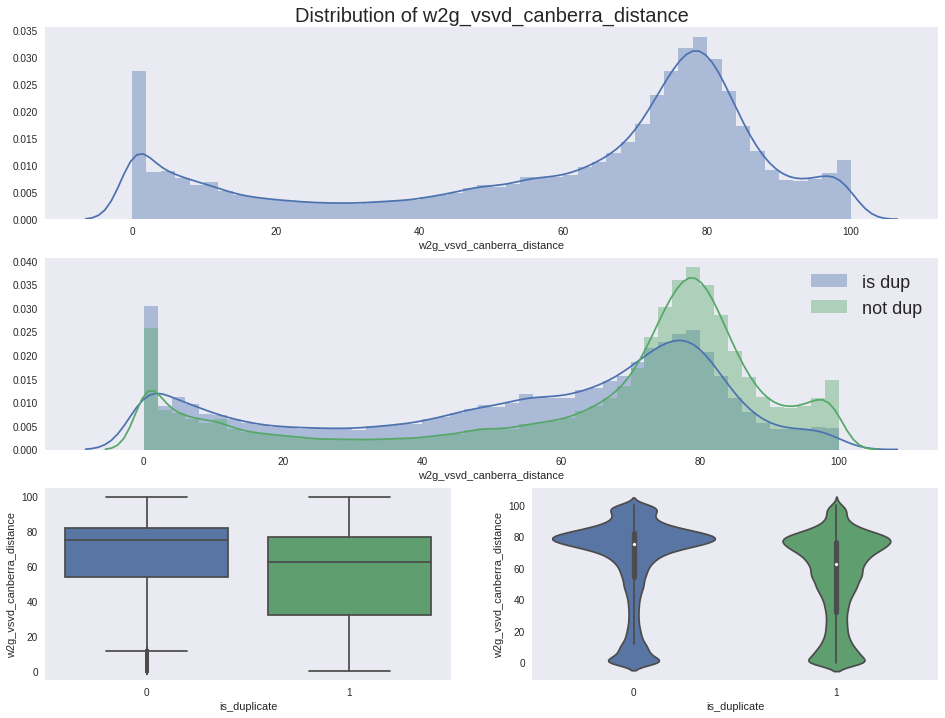

In [33]:
plot_real_feature('w2g_vsvd_canberra_distance')